In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/risk-behavior-features-analysis/risk_behavior_features.csv


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [31]:
# Set random seed for reproducibility
np.random.seed(42)

In [32]:
# Load data snd view top 5 rows
df = pd.read_csv('/kaggle/input/risk-behavior-features-analysis/risk_behavior_features.csv')
df.head()

,Age,Gender,Education Level,Marital Status,Number of Dependents,Income,Credit Score,Debt-to-Income Ratio,Assets Value,Defaults Records,Employment Status,Years in Current Job
0,36,Female,Bachelor's,Divorced,2,56789,715,0.25,158765,2,Employed,6
1,37,Non-binary,Master's,Single,3,91234,789,0.18,176543,0,Employed,10
2,45,Male,Bachelor's,Divorced,1,65432,723,0.25,134567,1,Employed,6
3,39,Male,Master's,Single,0,92345,801,0.15,192345,0,Employed,10
4,40,Female,Master's,Married,1,76543,756,0.22,162345,0,Employed,8


## 1. Data Exploration & EDA

In [33]:
# Display basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   73 non-null     int64  
 1   Gender                73 non-null     object 
 2   Education Level       73 non-null     object 
 3   Marital Status        73 non-null     object 
 4   Number of Dependents  73 non-null     int64  
 5   Income                73 non-null     int64  
 6   Credit Score          73 non-null     int64  
 7   Debt-to-Income Ratio  73 non-null     float64
 8   Assets Value          73 non-null     int64  
 9   Defaults Records      73 non-null     int64  
 10  Employment Status     73 non-null     object 
 11  Years in Current Job  73 non-null     int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 7.0+ KB
None

Summary Statistics:
             Age  Number of Dependents         Income  Credit Score  \
count  73.

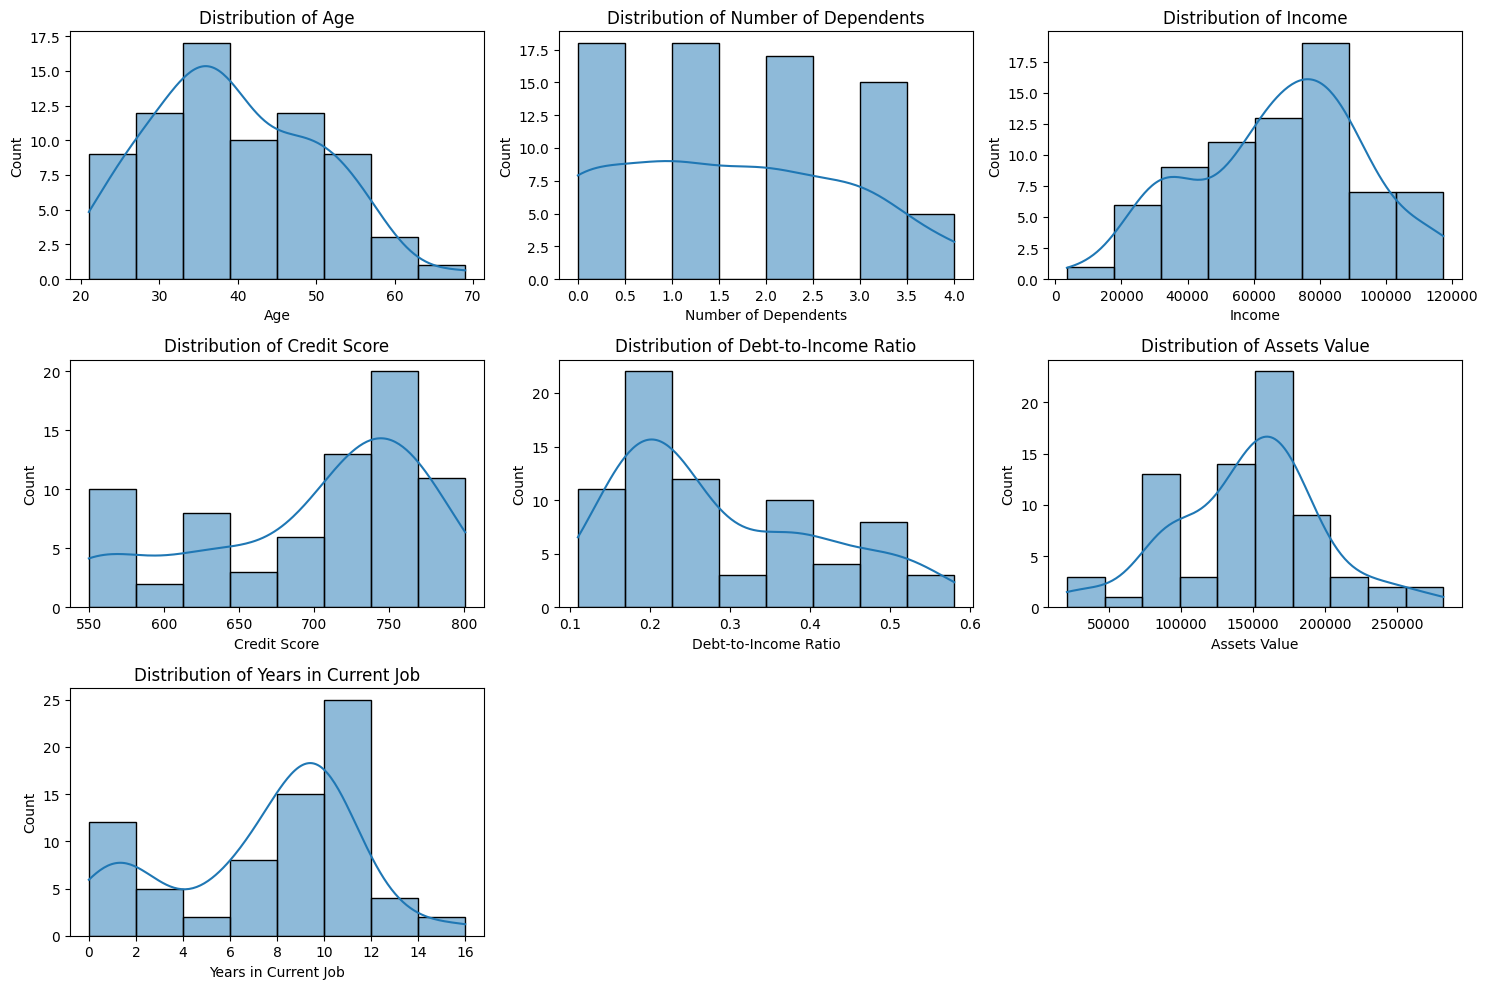

In [34]:
# Visualize distributions of numerical features
numerical_cols = ['Age', 'Number of Dependents', 'Income', 'Credit Score', 
                  'Debt-to-Income Ratio', 'Assets Value', 'Years in Current Job']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

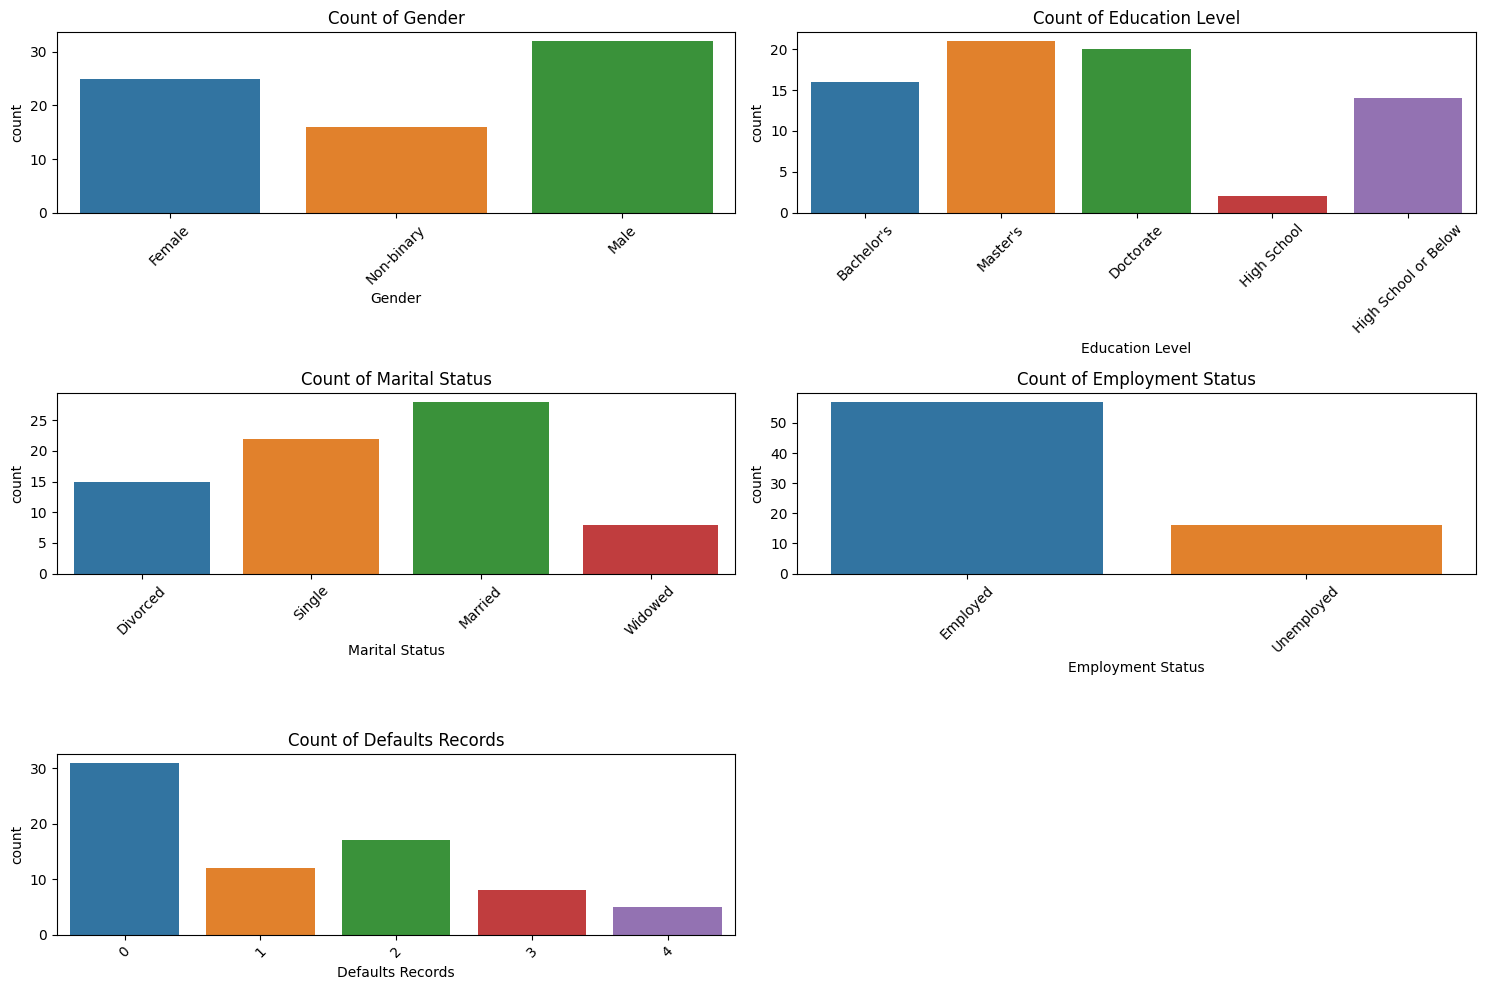

In [35]:
# Visualize categorical features
categorical_cols = ['Gender', 'Education Level', 'Marital Status', 'Employment Status', 'Defaults Records']
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=df, x=col)
    plt.title(f'Count of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

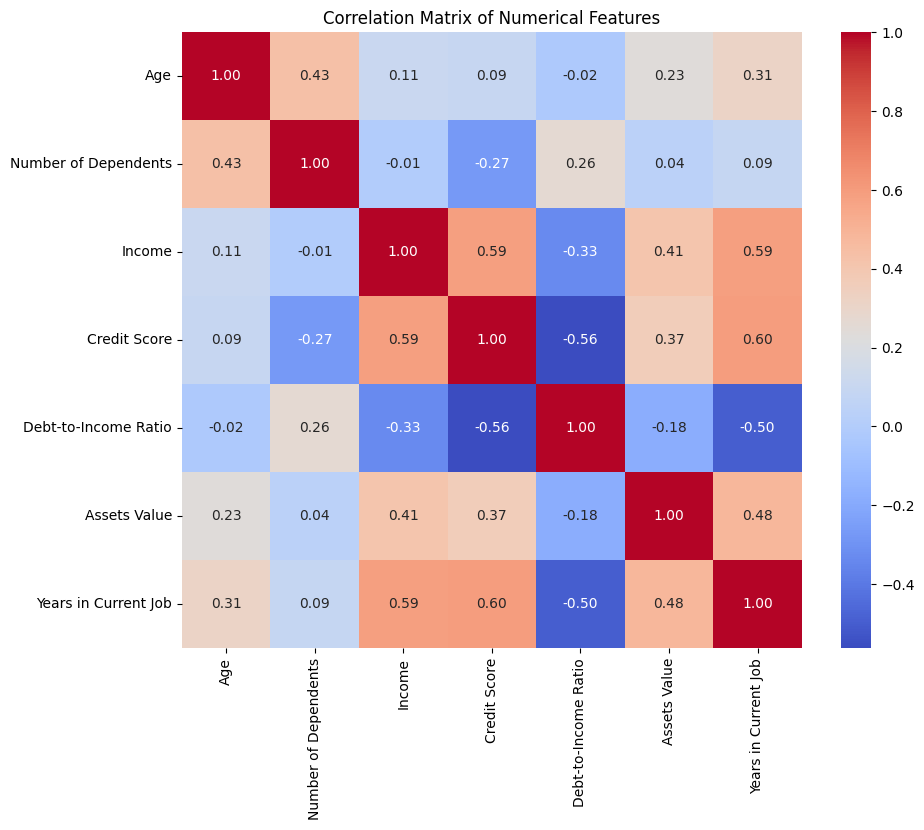

In [36]:
# Correlation matrix for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## 2. Data Preprocessing

In [37]:
# Define feature types
numerical_features = numerical_cols
categorical_features = ['Gender', 'Education Level', 'Marital Status', 'Employment Status']

In [38]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

In [39]:
# Apply preprocessing
X = preprocessor.fit_transform(df)

In [40]:
# Get feature names after one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(cat_feature_names)

In [41]:
# Convert to DataFrame
X_df = pd.DataFrame(X, columns=feature_names)

In [42]:
# Create a copy of the preprocessed data for later use
X_df_copy = X_df.copy()

## 3. Initial Clustering

In [43]:
# Apply K-Means with an initial guess of 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_df)

In [44]:
# Add cluster labels to the preprocessed DataFrame
X_df['Cluster'] = cluster_labels

In [45]:
# Evaluate the clustering
inertia = kmeans.inertia_
silhouette_avg = silhouette_score(X_df.drop('Cluster', axis=1), cluster_labels)

print("Clustering Results:")
print(f"Inertia: {inertia:.2f}")
print(f"Silhouette Score: {silhouette_avg:.3f}")
print("\nCluster assignments for the first few rows:")
print(X_df[['Cluster']].head())

Clustering Results:
Inertia: 364.07
Silhouette Score: 0.255

Cluster assignments for the first few rows:
   Cluster
0        1
1        1
2        1
3        1
4        1


In [46]:
# Elbow Method to determine optimal number of clusters
inertias = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_df_copy)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_df_copy, kmeans.predict(X_df_copy)))

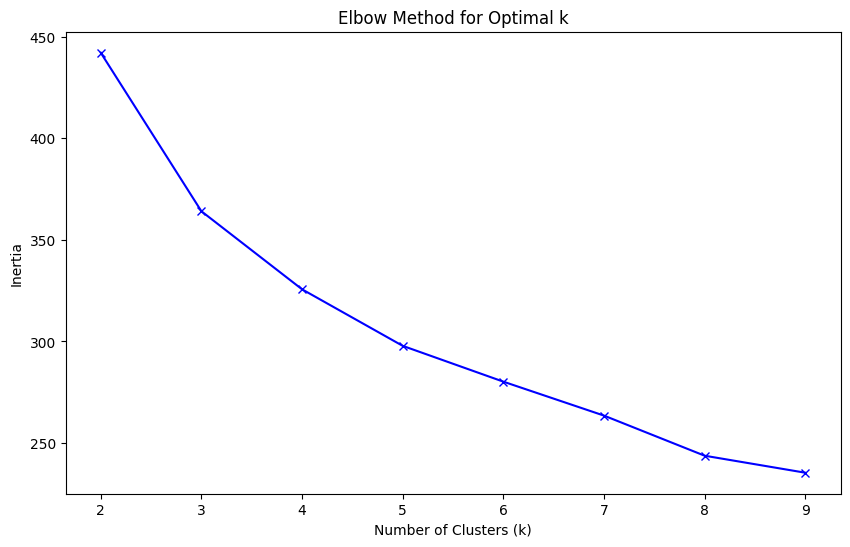

In [47]:
# Plot Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

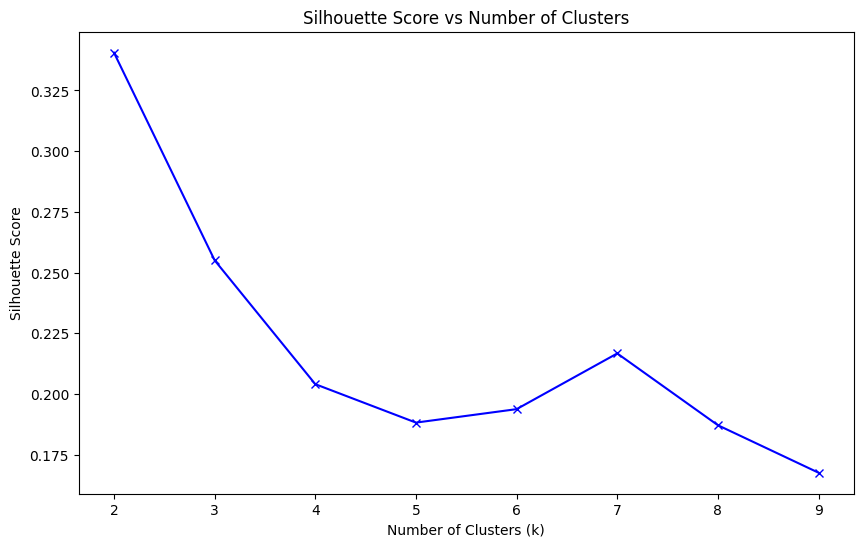

In [48]:
# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

## 4. Tuning

In [49]:
# K-Means with optimal k (based on elbow/silhouette)
optimal_k = K[np.argmax(silhouette_scores) + 2]  # Offset by 2 due to range start
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans_optimal.fit_predict(X_df_copy)

In [50]:
# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=optimal_k)
agglo_labels = agglo.fit_predict(X_df_copy)

In [51]:
# Apply DBSCAN with adjusted parameters
dbscan = DBSCAN(eps=1.0, min_samples=3)
dbscan_labels = dbscan.fit_predict(X_df_copy)

In [53]:
# Evaluate models
kmeans_silhouette = silhouette_score(X_df_copy, kmeans_labels)
agglo_silhouette = silhouette_score(X_df_copy, agglo_labels)
dbscan_silhouette = silhouette_score(X_df_copy[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if -1 in dbscan_labels else -1

print("Hyperparameter Tuning Results:")
print(f"Optimal k from Silhouette: {optimal_k}")
print(f"K-Means Silhouette Score (k={optimal_k}): {kmeans_silhouette:.3f}")
print(f"Agglomerative Clustering Silhouette Score (k={optimal_k}): {agglo_silhouette:.3f}")
print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.3f}")
print("\nCluster assignments for the first few rows:")
print(pd.DataFrame({
    'K-Means': kmeans_labels[:5],
    'Agglomerative': agglo_labels[:5],
    'DBSCAN': dbscan_labels[:5]
}))

Hyperparameter Tuning Results:
Optimal k from Silhouette: 4
K-Means Silhouette Score (k=4): 0.204
Agglomerative Clustering Silhouette Score (k=4): 0.203
DBSCAN Silhouette Score: 0.832

Cluster assignments for the first few rows:
   K-Means  Agglomerative  DBSCAN
0        2              2      -1
1        2              2      -1
2        2              3      -1
3        1              2      -1
4        2              2      -1


4 clusters may not be the best fit based on silhouette scores

In [54]:
# Test K-Means with 2 clusters
kmeans_2 = KMeans(n_clusters=2, random_state=42)
kmeans_2_labels = kmeans_2.fit_predict(X_df_copy)
kmeans_2_silhouette = silhouette_score(X_df_copy, kmeans_2_labels)

In [55]:
# Adjust DBSCAN parameters
dbscan_adjusted = DBSCAN(eps=1.5, min_samples=2)
dbscan_adjusted_labels = dbscan_adjusted.fit_predict(X_df_copy)
dbscan_adjusted_silhouette = silhouette_score(X_df_copy[dbscan_adjusted_labels != -1], dbscan_adjusted_labels[dbscan_adjusted_labels != -1]) if -1 in dbscan_adjusted_labels else -1

In [56]:
# Compare with best previous model (k=4)
kmeans_4 = KMeans(n_clusters=4, random_state=42)
kmeans_4_labels = kmeans_4.fit_predict(X_df_copy)
kmeans_4_silhouette = silhouette_score(X_df_copy, kmeans_4_labels)

In [57]:
# Select best model based on silhouette score
best_model = max([(kmeans_2_silhouette, 'K-Means (k=2)', kmeans_2_labels),
                  (kmeans_4_silhouette, 'K-Means (k=4)', kmeans_4_labels),
                  (dbscan_adjusted_silhouette, 'DBSCAN (adjusted)', dbscan_adjusted_labels)],
                 key=lambda x: x[0])
best_silhouette, best_model_name, best_labels = best_model

In [58]:
# Assign best labels to X_df_copy
X_df_copy['Cluster'] = best_labels

print("Model Refinement Results:")
print(f"Silhouette Score - K-Means (k=2): {kmeans_2_silhouette:.3f}")
print(f"Silhouette Score - K-Means (k=4): {kmeans_4_silhouette:.3f}")
print(f"Silhouette Score - DBSCAN (adjusted): {dbscan_adjusted_silhouette:.3f}")
print(f"Best Model: {best_model_name} with Silhouette Score: {best_silhouette:.3f}")
print("\nCluster assignments for the first few rows:")
print(X_df_copy[['Cluster']].head())

Model Refinement Results:
Silhouette Score - K-Means (k=2): 0.341
Silhouette Score - K-Means (k=4): 0.204
Silhouette Score - DBSCAN (adjusted): 0.367
Best Model: DBSCAN (adjusted) with Silhouette Score: 0.367

Cluster assignments for the first few rows:
   Cluster
0       -1
1       -1
2        0
3        1
4        0


The DBSCAN (adjusted) model with eps=1.5 and min_samples=2 appears to be the best fit based on the silhouette score.

## 5. Cluster Analysis and Interpretation

In [59]:
# Reverse the preprocessing to map clusters back to original features
# Note: For simplicity, we'll use the original df with cluster labels from X_df_copy
df_with_clusters = df.copy()
df_with_clusters['Cluster'] = X_df_copy['Cluster']

In [60]:
# Analyze cluster characteristics
cluster_stats = df_with_clusters.groupby('Cluster').agg({
    'Age': ['mean', 'std'],
    'Income': ['mean', 'std'],
    'Credit Score': ['mean', 'std'],
    'Debt-to-Income Ratio': ['mean', 'std'],
    'Assets Value': ['mean', 'std'],
    'Defaults Records': ['mean'],
    'Employment Status': lambda x: x.mode()[0],  # Most common employment status
    'Gender': lambda x: x.mode()[0],  # Most common gender
    'Education Level': lambda x: x.mode()[0],  # Most common education level
    'Marital Status': lambda x: x.mode()[0]  # Most common marital status
}).fillna(0)

print("Cluster Statistics:")
print(cluster_stats)

Cluster Statistics:
               Age                   Income               Credit Score  \
              mean        std          mean           std         mean   
Cluster                                                                  
-1       41.171429  11.720986  71337.714286  29072.760822   690.085714   
 0       43.894737   8.299228  75589.368421   7607.691665   750.842105   
 1       37.250000   1.258306  89721.750000   1752.705219   790.250000   
 2       26.750000   3.500000  32749.500000   1977.147524   552.250000   
 3       27.750000   1.500000  63636.250000   4937.616454   735.500000   
 4       37.500000   0.707107  81493.500000    716.299169   759.000000   
 5       29.000000   4.242641  32456.000000   1571.191268   555.000000   
 6       34.000000   1.000000  24141.333333  17866.905981   562.333333   

                   Debt-to-Income Ratio             Assets Value  \
               std                 mean       std           mean   
Cluster                      

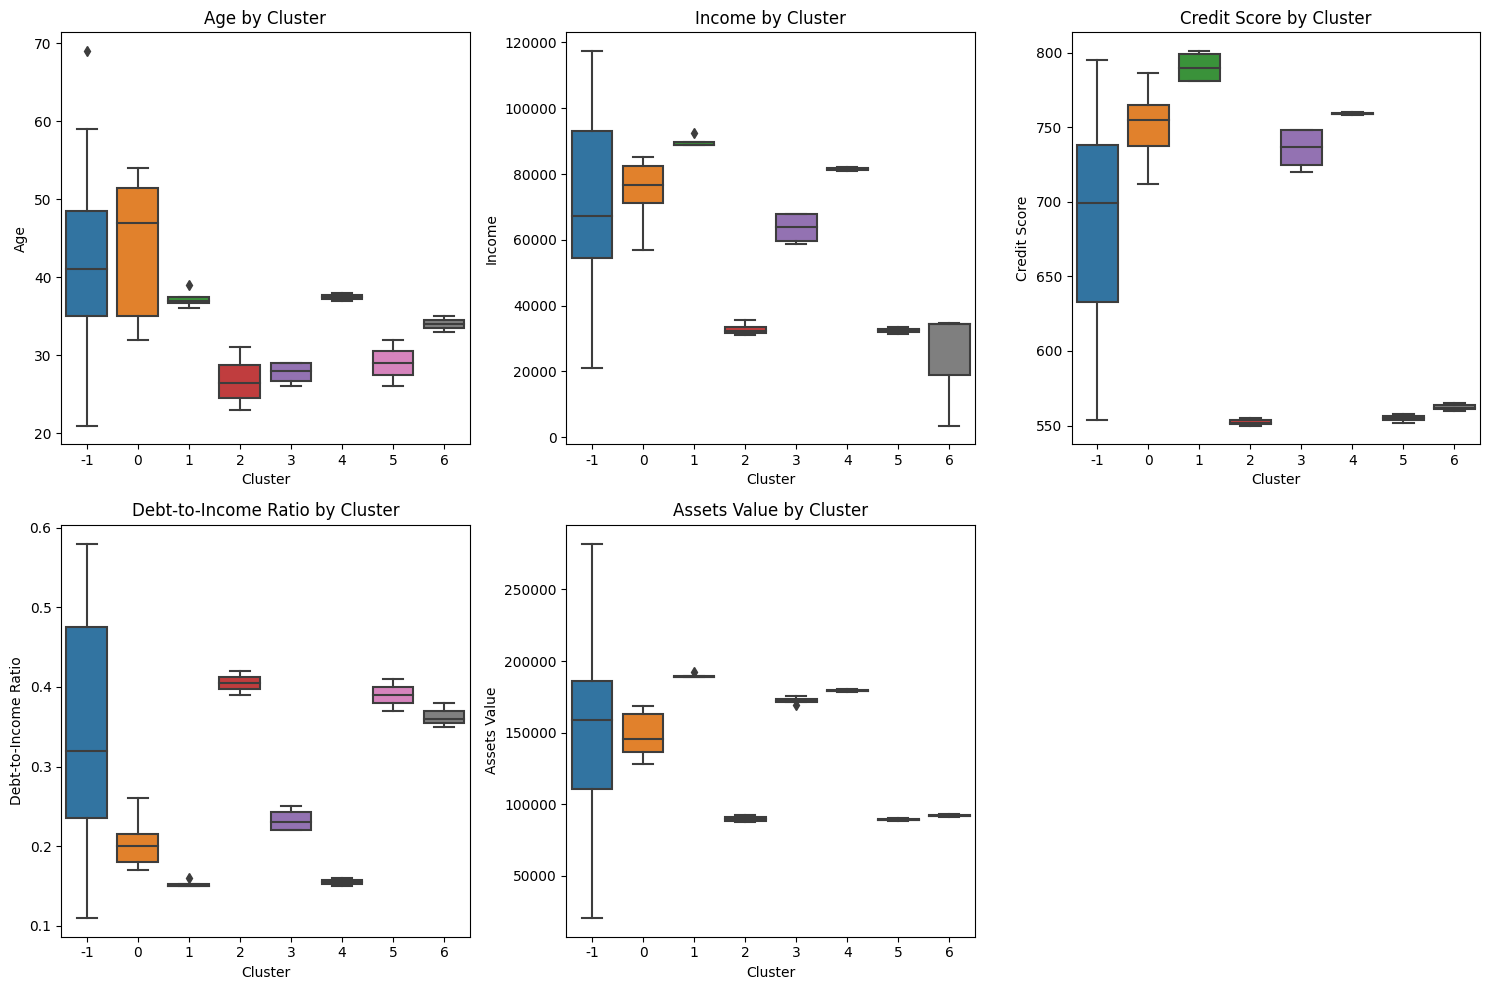

In [61]:
# Visualize cluster distributions for key numerical features
numerical_cols = ['Age', 'Income', 'Credit Score', 'Debt-to-Income Ratio', 'Assets Value']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Cluster', y=col, data=df_with_clusters)
    plt.title(f'{col} by Cluster')
plt.tight_layout()
plt.show()

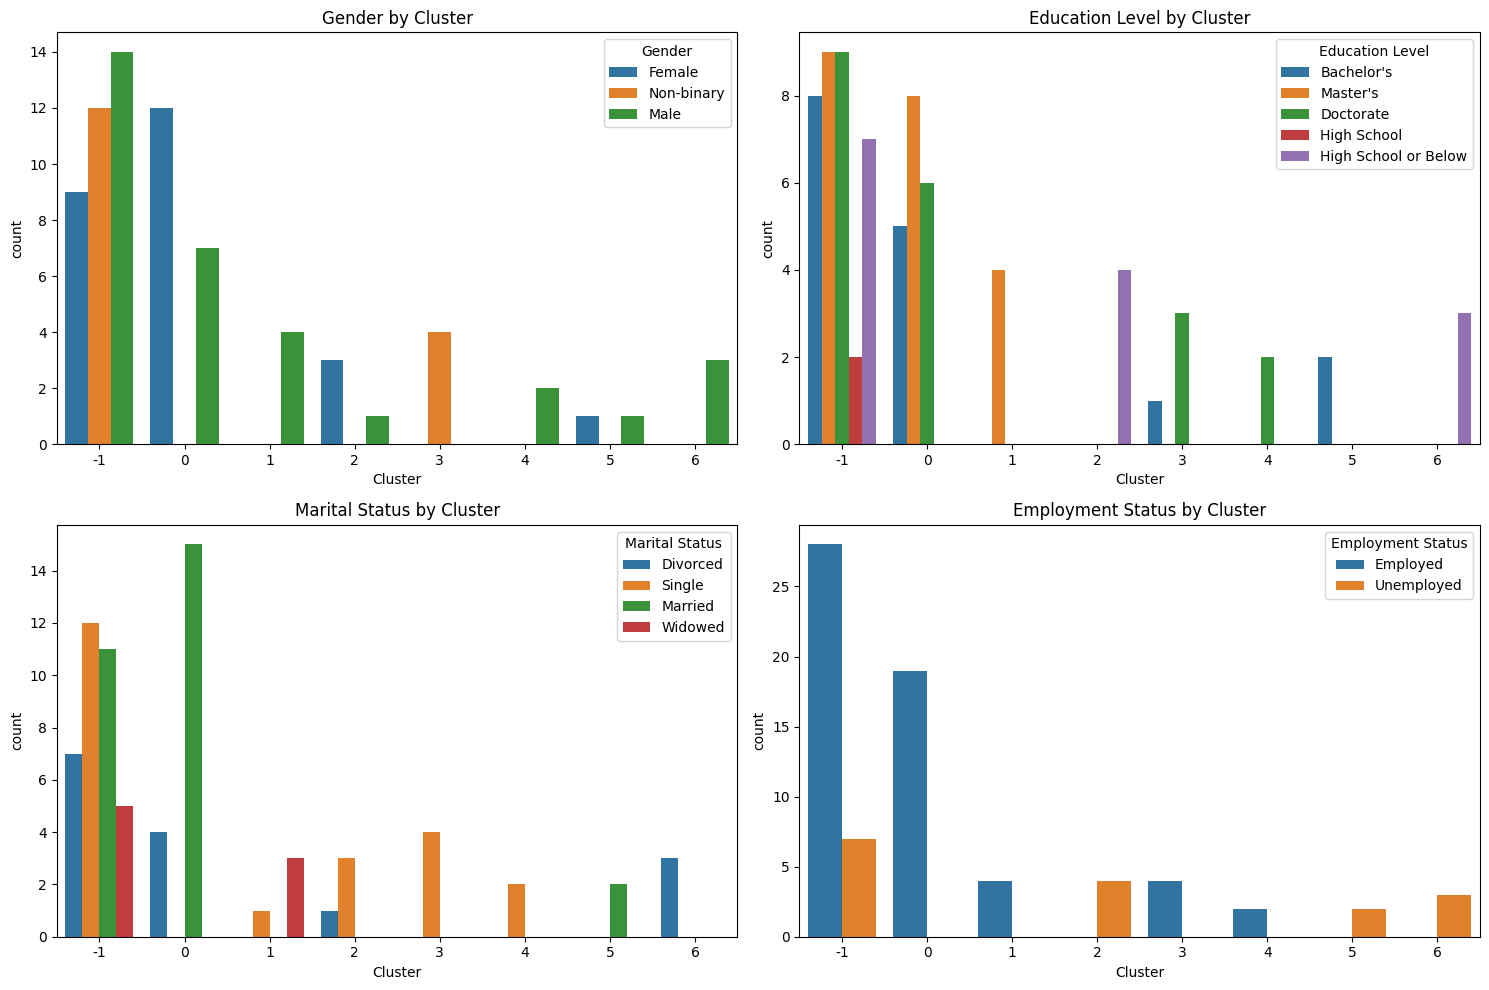

In [62]:
# Count plot for categorical variables by cluster
categorical_cols = ['Gender', 'Education Level', 'Marital Status', 'Employment Status']
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x='Cluster', hue=col, data=df_with_clusters)
    plt.title(f'{col} by Cluster')
plt.tight_layout()
plt.show()